## Погодные условия.

In [115]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import datetime

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Загрузим сначала датасет с данными о погоде в каждый день.

In [34]:
weather_data = pd.read_csv('cycle-share-dataset/weather.csv',
                           parse_dates=[0], na_values='-')

trips = pd.read_csv('cycle-share-dataset/trip.csv', error_bad_lines=False,
                   parse_dates=[1, 2])


weather_data.head()

b'Skipping line 50794: expected 12 fields, saw 20\n'


,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.79,29.65,10,10,4,13,4,21.0,0.00,Rain
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.75,29.54,10,9,3,10,5,17.0,0.11,Rain
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.71,29.51,10,9,3,18,7,25.0,0.45,Rain
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.95,29.81,10,10,10,9,4,NaN,0.00,Rain
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.78,29.73,10,10,6,8,3,NaN,0.14,Rain


Посмотрим на колонки в датасете о погоде.

In [33]:
weather_data.columns

Index(['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_Pressure_In',
       'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
       'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles',
       'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH',
       'Precipitation_In', 'Events'],
      dtype='object')

Исследуем сначала зависимость дневного числа поездок от различных погодных факторов.

Добавим признаки числа, месяца и дня недели для дальнейшего удобства.

In [47]:
time_data = trips[['trip_id', 'starttime', 'stoptime']].copy()

time_data['start_year'] = time_data['starttime'].dt.year
time_data['start_month'] = time_data['starttime'].dt.month
time_data['start_day'] = time_data['starttime'].dt.day
time_data['start_date'] = time_data['starttime'].dt.date
time_data['start_time'] = time_data['starttime'].dt.date
time_data['start_weekday'] = time_data['starttime'].dt.dayofweek

time_data['stop_year'] = time_data['stoptime'].dt.year
time_data['stop_month'] = time_data['stoptime'].dt.month
time_data['stop_day'] = time_data['stoptime'].dt.day
time_data['stop_date'] = time_data['stoptime'].dt.date
time_data['stop_time'] = time_data['stoptime'].dt.date
time_data['stop_weekday'] = time_data['stoptime'].dt.dayofweek

time_data.drop(columns=['starttime', 'stoptime'], inplace=True)

Количество поездок в зависимости от дня.

In [48]:
trips_by_date = time_data.groupby('start_date').count()['trip_id']

trips_by_date = pd.DataFrame(trips_by_date).reset_index()

trips_by_date.columns = ['Date','trip_num']

trips_by_date.loc[:, 'Date'] = pd.to_datetime(trips_by_date['Date'])

trips_by_date.head()

,Date,trip_num
0,2014-10-13,818
1,2014-10-14,982
2,2014-10-15,626
3,2014-10-16,790
4,2014-10-17,588


Соединим две полученные таблицы.

In [49]:
trips_weather = weather_data.merge(trips_by_date, how='left', on='Date')

trips_weather.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events,trip_num
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.65,10,10,4,13,4,21.0,0.00,Rain,818
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.54,10,9,3,10,5,17.0,0.11,Rain,982
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.51,10,9,3,18,7,25.0,0.45,Rain,626
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.81,10,10,10,9,4,NaN,0.00,Rain,790
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.73,10,10,6,8,3,NaN,0.14,Rain,588


Можно видеть, что признак `Events` задаётся в текстовом формате.

В дальнейшем, при обучении моделей и проверке гипотез будем проводить label encoding для этого признака.

In [133]:
events = trips_weather.Events.dropna()

le = LabelEncoder()
le.fit(events)

LabelEncoder()

Попробуем сначала визуально оценить зависимость числа поездок от указанных погодных параметров.

In [50]:
trips_weather.columns[1:-2].shape[0]

19

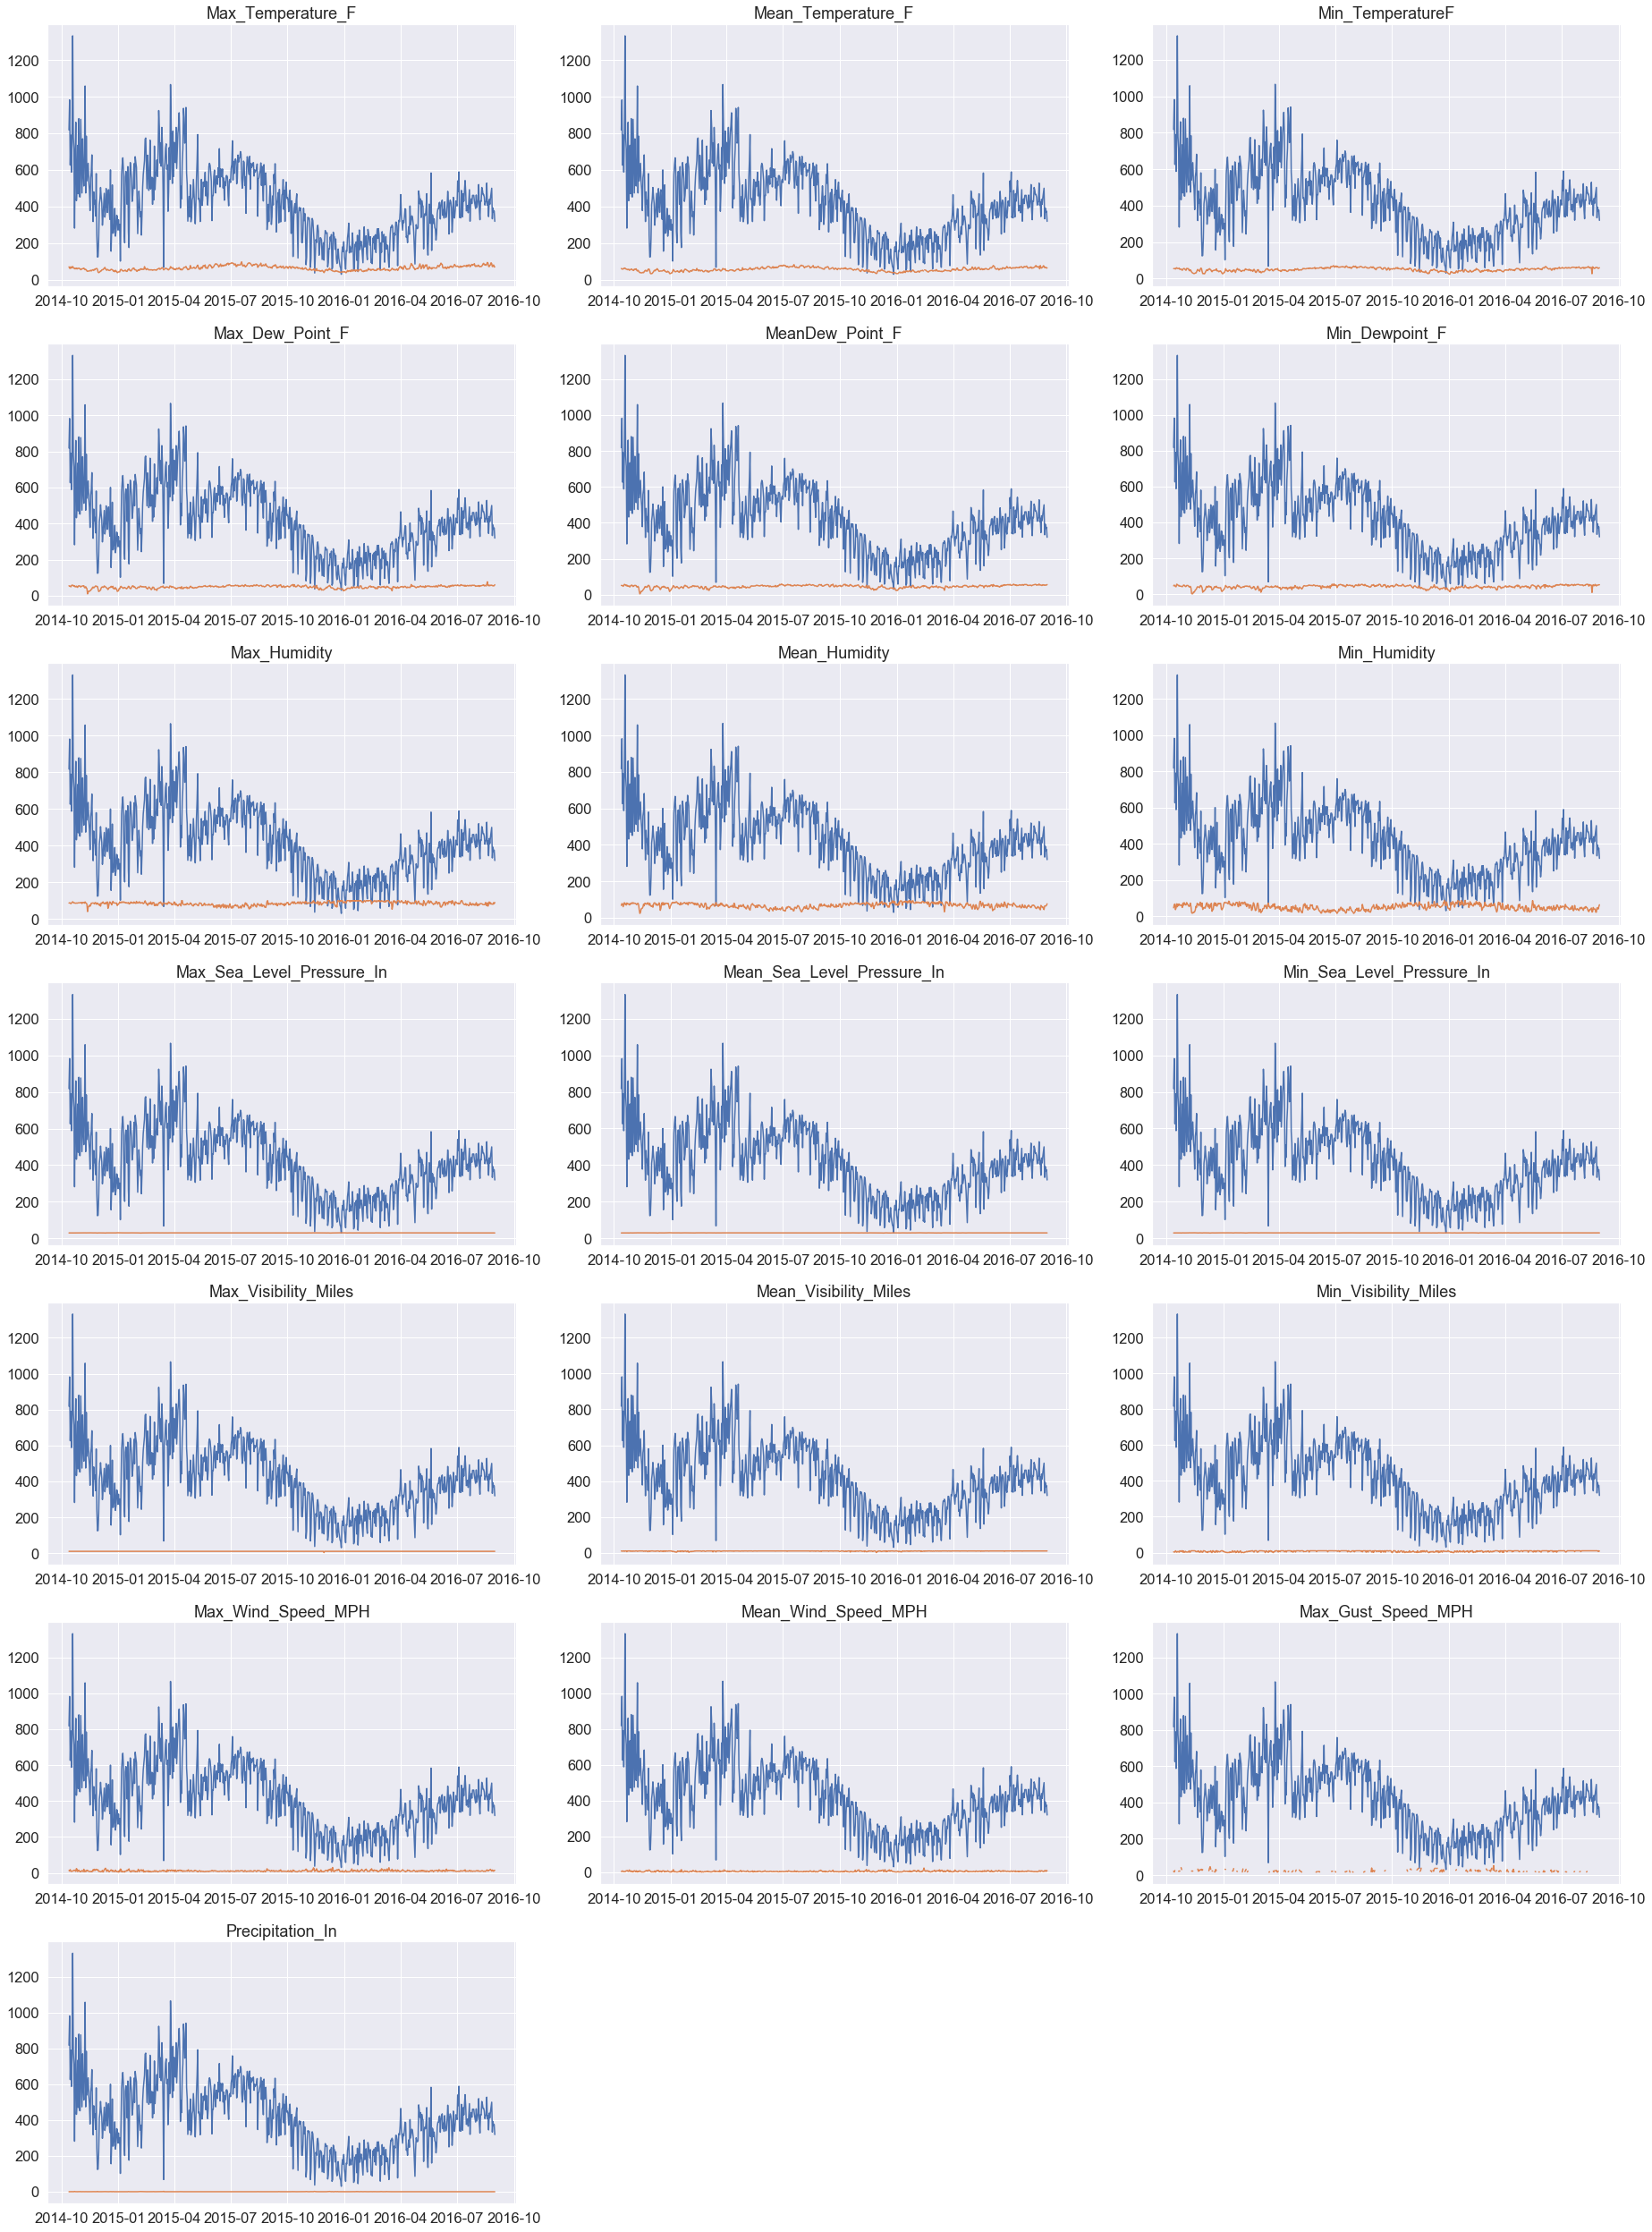

In [136]:
plt.figure(figsize=(26, 35))

for i, column in enumerate(trips_weather.columns[1:-2]):
    plt.subplot(7, 3, i+1)
    plt.title(column)
        
    plt.plot(trips_weather.Date, trips_weather.trip_num, label='trip_num')
    plt.plot(trips_weather.Date, trips_weather[column], label='признак')
        
plt.tight_layout()

По графикам можно предположить, что количество поездок зависит от температуры, влажности, точки росы.

Также, можно видеть, что в колонке `Max_gust_Speed_MPH` много пропущенных значений. Уберём его пока из рассмотрения.

Вспомним предыдущий семестр. Будем использовать регрессию для отбора признаков. Наиболее подходящей для отбора признаков является Лассо-регрессия. Для отбора признаков разделим сначала выборку на train и test. Затем, будем проходиться по всем подмножествам признаков и счиать качество обученной модели.

In [130]:
class BestFeaturesSelection:
    def __init__(self, estimator, scoring, parameters=dict(), 
                 test_size=0.3, random_state=17, minimize=True):
        """
        Отбор наилучших признаков
        estimator: конструктор класса, например, LinearRegression
        paramters: параметры, передаваемые конструктору estimator, 
                    например dict(fit_intercept=False)
        scoring: функция риска, например, mean_squared_error
        minimize: минимизировать ли функционал качества 
                    (иначе - максимизировать)
        """
        
        self.estimator = estimator
        self.parameters = parameters
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        self.minimize=minimize
        
    def fit(self, X, y):
        """
        Подбор лучшего подмножества признаков 
        и обучение модели на нём
        """
        
        # разделение выборки на test и train.
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.3, 
                                                            random_state=17)
        # стандартизирование признаков
        scaler = StandardScaler()
        
        self.results_ = []  # список пар (вектор использованных признаков, 
                            # значение функции потерь)
        features_count = X.shape[1]
        
        for bitmask in tqdm(range(1, 2 ** features_count)):
            subset = [i == "1" for i in \
                      np.binary_repr(bitmask, width=features_count)]
            # binary_repr возвращает строку длины width с двоичным 
            # представлением числа и ведущими нулями
            
            x_train = scaler.fit_transform(X_train[:, subset])
            x_test = scaler.transform(X_test[:, subset])
            
            reg = self.estimator(**self.parameters)
            reg.fit(X_train[:, subset], y_train)
            
            score = self.scoring(y_test, reg.predict(X_test[:, subset]))
            # вычисление качества модели
    
            self.results_.append((subset, score))
        
        self.results_.sort(key = lambda pair: pair[1],
                           reverse=not self.minimize) 
        # сортируем по второму элементу в нужном порядке
        
        self._best_subset = self.results_[0][0]
        self._best_estimator = self.estimator(**self.parameters)
        self._best_estimator.fit(X_train[:, self._best_subset], y_train)
        
        return self._best_estimator
        
    def predict(self, X):
        """
        Предсказание модели, 
        обученной на наилучшем подмножестве признаков.
        """
        
        return self._best_estimator.predict(X[:, self._best_subset]);

In [131]:
valid_data = trips_weather.iloc[:, 1:-3].copy()
valid_data['trip_num'] = trips_weather.trip_num
valid_data.dropna(inplace=True)

X = valid_data.values[:, :-1]
y = valid_data.values[:, -1]

bfs = BestFeaturesSelection(Lasso,
                            mean_squared_error)

In [132]:
bfs.fit(X, y)

/Users/gregorypolyakov/opt/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.6356730181724, tolerance: 793.7842871794873

/Users/gregorypolyakov/opt/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.6356730181724, tolerance: 793.7842871794873

/Users/gregorypolyakov/opt/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.9687269581482, tolerance: 793.7842871794873

/Users/gregorypolyakov/opt/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converge

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [134]:
values = np.array(bfs._best_subset).reshape(-1, 1)

answer = pd.DataFrame(values, index = valid_data.columns[:-1],
                      columns=['Значимый ли'])
answer

,Значимый ли
Max_Temperature_F,False
Mean_Temperature_F,True
Min_TemperatureF,True
Max_Dew_Point_F,False
MeanDew_Point_F,True
Min_Dewpoint_F,False
Max_Humidity,True
Mean_Humidity,True
Min_Humidity,True
Max_Sea_Level_Pressure_In,True


Можем видеть, что почти все наши предположения подтвердились. Значимым также оказался достаточно неожиданный признак `Max_Sea_Level_Pressure_In`.

Проведём аналогичное исследование с помощью коэффициентов корреляции. Для каждого признака будем проводить тесты (вычисления коэффициентов корреляции) Пирсона, Спирмена и Кендалла. Затем сделаем поправку на множественную проверку гипотез.

Если один из трёх критериев после МПГ для какого либо признака отвергает гипотезу о независимости, то отвергаем независимоть для данного признака.

In [108]:
p_values = []

for column in trips_weather.columns[1:-2]:
    
    data = trips_weather.loc[:, ['trip_num', column]].dropna()
    p_values.append(sps.spearmanr(data.trip_num, data[column])[1])
    p_values.append(sps.kendalltau(data.trip_num, data[column])[1])
    p_values.append(sps.pearsonr(data.trip_num, data[column])[1])

In [114]:
rejected = multipletests(p_values)[0]

spear_rejected = rejected[0::3]
ken_rejected = rejected[1::3]
pears_rejected = rejected[2::3]

rejected = np.logical_or(spear_rejected, ken_rejected)
rejected = np.logical_or(rejected, pears_rejected)

In [113]:
answer = pd.DataFrame(rejected, index = trips_weather.columns[1:-2],
                      columns=['Отверглась ли гипотеза о независимости'])
answer

,Отверглась ли гипотеза о независимости
Max_Temperature_F,True
Mean_Temperature_F,True
Min_TemperatureF,True
Max_Dew_Point_F,True
MeanDew_Point_F,True
Min_Dewpoint_F,True
Max_Humidity,True
Mean_Humidity,True
Min_Humidity,True
Max_Sea_Level_Pressure_In,False


***Вывод:***

После корреляционного анализа мы получили, что для почти всех признаков отверглась гипотеза о независимости от количества поездок. Примечательно, что количество поездок зависит даже от атмосферного давления.

Для подбора признаков при обучении каких-либо моделей стоит скорее использовать результат, полученный с помощью лассо-регрессии.

***To Do:*** 

Для датасетов о перебросах и групповых поездок провести аналогичное исследование.